In [109]:
import os
import sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

generate_random_graph = False
maximize_independent_C_nodes = False

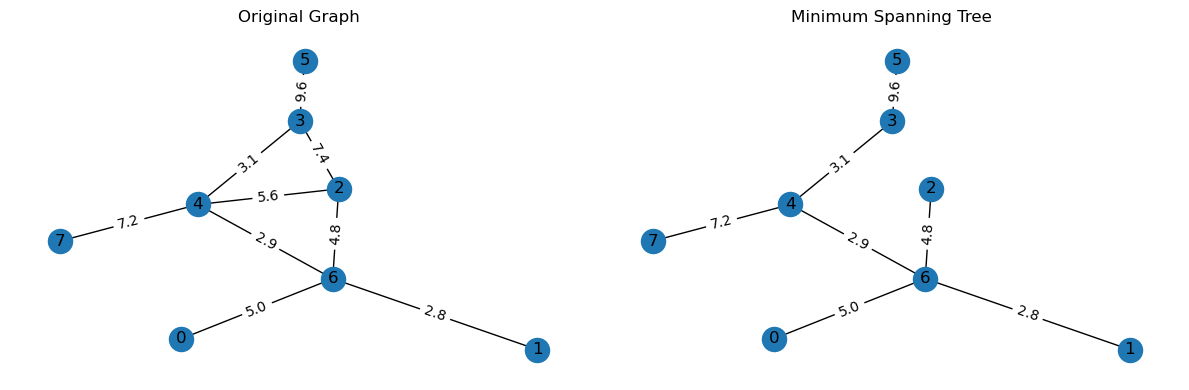

In [110]:
if generate_random_graph:
    # Generate a random graph
    number_of_nodes = 8
    number_of_edges = 9
    G = nx.gnm_random_graph(number_of_nodes, number_of_edges)
    
    # Ensure the graph is connected
    while not nx.is_connected(G):
        # Find connected components
        components = list(nx.connected_components(G))
        for i in range(1, len(components)):
            node_from_prev = list(components[i - 1])[0]
            node_from_curr = list(components[i])[0]
            G.add_edge(node_from_prev, node_from_curr)
            
    # Add random weights to the edges
    for (u, v) in G.edges():
        # Only with one decimal place
        G[u][v]['weight'] = round(np.random.uniform(0.1, 10), 1)
else:
    # Define the graph
    edges_with_weights = [
        (0, 6, 5.0),
        (1, 6, 2.8),
        (6, 4, 2.9),
        (6, 2, 4.8),
        (2, 4, 5.6),
        (4, 3, 3.1),
        (4, 7, 7.2),
        (3, 5, 9.6),
        (3, 2, 7.4)
    ]

    # Create the graph
    G = nx.Graph()
    G.add_weighted_edges_from(edges_with_weights)
        
# Compute the layout for the graph
pos = nx.spring_layout(G)

# Compute the Minimum Spanning Tree (MST) using NetworkX's API
MST = nx.minimum_spanning_tree(G, weight='weight')

# Visualize the graph and MST in 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the original graph
plt.sca(axes[0])
nx.draw(G, pos, with_labels=True, ax=axes[0])
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[0])
axes[0].set_title("Original Graph")

# Plot the Minimum Spanning Tree
plt.sca(axes[1])
nx.draw(MST, pos, with_labels=True, ax=axes[1])
edge_labels = nx.get_edge_attributes(MST, 'weight')
nx.draw_networkx_edge_labels(MST, pos, edge_labels=edge_labels, ax=axes[1])
axes[1].set_title("Minimum Spanning Tree")

plt.tight_layout()
plt.show()

In [111]:
# Compute parent and children relationships for the MST
parent_children = {}

# Use a Depth-First Search (DFS) to extract parent-child relationships
for edge in nx.dfs_edges(MST):
    parent, child = edge
    # Add child to parent's list
    if parent not in parent_children:
        parent_children[parent] = {'children': [], 'parent': None}
    if child not in parent_children:
        parent_children[child] = {'children': [], 'parent': None}
    parent_children[parent]['children'].append(child)
    # Set child's parent
    parent_children[child]['parent'] = parent

# Display the parent-children relationships
node_relationships = {
    node: {
        "Parent": relationships["parent"],
        "Children": relationships["children"]
    }
    for node, relationships in parent_children.items()
}

# Display the parent-children relationships without ace_tools
df = pd.DataFrame(node_relationships).T

# Add the 'Degree' column (number of children + 1 if parent exists)
df['Degree'] = df['Children'].apply(len) + df['Parent'].notnull().astype(int)

if maximize_independent_C_nodes:
    # Reset roles to 'D'
    df['Role'] = 'D'

    # Initialize set to track nodes assigned as 'C'
    assigned_C_nodes = set()

    # Sort nodes by their degree (ascending) to prioritize leaf nodes first
    nodes_sorted_by_degree = df['Degree'].sort_values().index

    # Assign 'C' to as many nodes as possible without direct connections in the original graph
    for node in nodes_sorted_by_degree:
        neighbors = set(G.neighbors(node))
        if not assigned_C_nodes.intersection(neighbors):  # Ensure no neighbors are already 'C'
            df.loc[node, 'Role'] = 'C'
            assigned_C_nodes.add(node)
else: # Maximize the degree of 'C' nodes while ensuring no direct neighbors are 'C'
    # Reset roles to 'D'
    df['Role'] = 'D'

    # Initialize set to track nodes assigned as 'C'
    assigned_C_nodes = set()

    # Sort nodes by their degree (descending) to prioritize high-degree nodes first
    nodes_sorted_by_degree = df['Degree'].sort_values(ascending=False).index

    # Assign 'C' to as many nodes as possible while maximizing the degree and ensuring no direct neighbors are 'C'
    for node in nodes_sorted_by_degree:
        neighbors = set(G.neighbors(node))
        if not assigned_C_nodes.intersection(neighbors):  # Ensure no neighbors are already 'C'
            df.loc[node, 'Role'] = 'C'
            assigned_C_nodes.add(node)
    
# Display
df.sort_index()

,Parent,Children,Degree,Role
0,None,[6],1,D
1,6,[],1,D
2,6,[],1,D
3,4,[5],2,C
4,6,"[3, 7]",3,D
5,3,[],1,D
6,0,"[1, 4, 2]",4,C
7,4,[],1,C


In [112]:
nx.laplacian_matrix(MST, weight=None).toarray()

array([[ 1, -1,  0,  0,  0,  0,  0,  0],
       [-1,  4, -1, -1, -1,  0,  0,  0],
       [ 0, -1,  1,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  3,  0, -1, -1,  0],
       [ 0, -1,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  2,  0, -1],
       [ 0,  0,  0, -1,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  1]])